# Анализ данных о покупках в торговых центрах Стамбула (2021-2023)

## 0. Импорт библиотек и установка констант

Импортируем необходимые библиотеки для анализа и визуализации. Устанавливаем стиль графиков и цветовые схемы для единообразия.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt

# from pylab import rcParams
# rcParams['figure.figsize'] = 20,10

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap

In [10]:
COLOR = "#8c57f8"
purple_palette = ['#2E0854', "#F62CEF", '#8A2BE2', "#E71384", "#88314F", "#EEBBFB"]
colors = sns.color_palette('pastel')
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

## 1. Чистка и EDA всего датасета

Скачиваем и загружаем [данные](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset)

In [11]:
!wget -O 'shopping_mall.csv' -q "https://www.dropbox.com/scl/fi/x38kses8p56prh6x78mnl/customer_shopping_data-2.csv?rlkey=xijf22o5dh0netxc2kyzo8pdg&st=2e5wpuf0&dl=0"

In [12]:
df = pd.read_csv('shopping_mall.csv')

Выведем первые 10 строк датасета

In [13]:
df.head(10)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon
5,I227836,C657758,Female,28,Clothing,5,1500.40,Credit Card,24/05/2022,Forum Istanbul
6,I121056,C151197,Female,49,Cosmetics,1,40.66,Cash,13/03/2022,Istinye Park
7,I293112,C176086,Female,32,Clothing,2,600.16,Credit Card,13/01/2021,Mall of Istanbul
8,I293455,C159642,Male,69,Clothing,3,900.24,Credit Card,4/11/2021,Metrocity
9,I326945,C283361,Female,60,Clothing,2,600.16,Credit Card,22/08/2021,Kanyon


In [14]:
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')

Размер датасета: 99457 строк, 10 столбцов


Смотрим, есть ли в данных полные дубликаты, и удаляем их при наличии

In [15]:
cnt_duplicated = df.duplicated().sum()
df = df.drop_duplicates()
cnt_dup_2 = df.duplicated().sum()

print(f"Количество дубликатов {cnt_duplicated} --> {cnt_dup_2}\nРазмер датасета (до и после удаления полных дубликатов): {df.shape[0]} --> {df.shape[0]}")

Количество дубликатов 0 --> 0
Размер датасета (до и после удаления полных дубликатов): 99457 --> 99457


Смотрим, есть ли пропуски в данных, и заполняем их при необходимости

In [16]:
print('В данных нет пропущенных значений') if df.isna().sum().sum() == 0 else print('В данных есть пропущенные значения')

В данных нет пропущенных значений


**Вывод:** Пропущенных значений в данных не обнаружено, что исключает необходимость их заполнения.

Выведем общую информацию о датасете

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


Смысл столбцов:
- `invoice_no` — номер счета/операции (уникальный буквенно-цифровой идентификатор)

- `customer_id` — идентификатор операции клиента (уникальный)

- `gender` — пол клиента

- `age` — возраст клиента (целое число)

- `category` — категория купленного товара

- `quantity` — количество товара в операции

- `price` — цена за единицу товара (в турецких лирах)

- `payment_method` — способ оплаты (наличные, кредитная карта, дебетовая карта)

- `invoice_date` — дата совершения операции

- `shopping_mall` — торговый центр, где совершена покупка

Видно, что pandas отнёс столбец `invoice_date` к общему типу object, поэтому приведем его к типу datetime, чтобы использовать удобные функции для манипуляций с датами

In [18]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

In [19]:
print("Тип данных invoice_date после преобразования:", df['invoice_date'].dtype)

Тип данных invoice_date после преобразования: datetime64[ns]


После преобразования посмотрим на итоговые типы данных

In [20]:
df.dtypes

,0
invoice_no,object
customer_id,object
gender,object
age,int64
category,object
quantity,int64
price,float64
payment_method,object
invoice_date,datetime64[ns]
shopping_mall,object


In [21]:
print(f"Период данных: с {df['invoice_date'].min()} по {df['invoice_date'].max()}")
print(f"Всего уникальных транзакций: {df['invoice_no'].nunique()}")

Период данных: с 2021-01-01 00:00:00 по 2023-03-08 00:00:00
Всего уникальных транзакций: 99457


**Вывод:** Данные охватывают период с января 2021 по март 2023 года, содержат 99457 уникальных транзакций.

## 2. Описательные статистики для числовых полей

In [22]:
numeric_columns = df.select_dtypes(include = np.number).columns
print(f'Числовые поля: {numeric_columns.to_list()}')

Числовые поля: ['age', 'quantity', 'price']


Анализируем описательные статистики для числовых полей - возраста, количества товаров и цены.

In [23]:
for col in numeric_columns:
    print(f"\n--- {col} --- ")
    print(f"Среднее значение: {df[col].mean():.2f}")
    print(f"Медиана: {df[col].median():.2f}")
    print(f"Стандартное отклонение: {df[col].std():.2f}")
    print(f"Минимальное значение: {df[col].min():.2f}")
    print(f"Максимальное значение: {df[col].max():.2f}")
    print(f"Квартили: 25% - {df[col].quantile(0.25):.2f}, 50% - {df[col].quantile(0.5):.2f}, 75% - {df[col].quantile(0.75):.2f}")


--- age --- 
Среднее значение: 43.43
Медиана: 43.00
Стандартное отклонение: 14.99
Минимальное значение: 18.00
Максимальное значение: 69.00
Квартили: 25% - 30.00, 50% - 43.00, 75% - 56.00

--- quantity --- 
Среднее значение: 3.00
Медиана: 3.00
Стандартное отклонение: 1.41
Минимальное значение: 1.00
Максимальное значение: 5.00
Квартили: 25% - 2.00, 50% - 3.00, 75% - 4.00

--- price --- 
Среднее значение: 689.26
Медиана: 203.30
Стандартное отклонение: 941.18
Минимальное значение: 5.23
Максимальное значение: 5250.00
Квартили: 25% - 45.45, 50% - 203.30, 75% - 1200.32


**Выводы по описательным статистикам числовых полей:**
- **`Возраст`:** Распределение от 18 до 69 лет, средний возраст покупателя - 43. Также стоит заметить, что покупатели в среднем зрелого возраста.
- **`Количество`:** Покупатели в среднем покупают 3 единицы товара
- **`Цена`:** Высокое стандартное отклонение указывает на значительный разброс цен,что говорит о разнообразии товарного ассортимента.

Таким образом, данные имеют разнородную структуру, присутствуют выбросы в ценах, что характерно для мультикатегорийной розницы.

## 3. Преобразование данных и создание новых переменных

Создадим новые переменные для расширенного анализа

In [24]:
df['purchase_sum'] = df['quantity'] * df['price']
df['month'] = df['invoice_date'].dt.month
df['year'] = df['invoice_date'].dt.year
df['day_of_week'] = df['invoice_date'].dt.day_name()
df['day_of_year'] = df['invoice_date'].dt.dayofyear

In [25]:
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    elif age <= 35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    elif age <= 65:
        return '56-65'
    else:
        return '65+'

df['age_group'] = df['age'].apply(age_group)

In [26]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

Созданные новые переменные:
- `purchase_sum`: общая сумма покупки
- `month`: месяц покупки
- `year`: год покупки
- `day_of_week`: день недели
- `day_of_year`: номер дня в году
- `age_group`: возрастная группа
- `season`: сезон года

Статистика для числового поля `purchase_sum`:

In [27]:
print(f"Средний чек: {df['purchase_sum'].mean():.2f}")
print(f"Медианный чек: {df['purchase_sum'].median():.2f}")
print(f"Максимальный чек: {df['purchase_sum'].max():.2f}")
print(f"Минимальный чек: {df['purchase_sum'].min():.2f}")
print(f"Стандартное отклонение: {df['purchase_sum'].std():.2f}")

Средний чек: 2528.79
Медианный чек: 600.17
Максимальный чек: 26250.00
Минимальный чек: 5.23
Стандартное отклонение: 4222.48


## 4. Визуализация данных

#### 4.1 Визуализируем распределение возраста покупателей

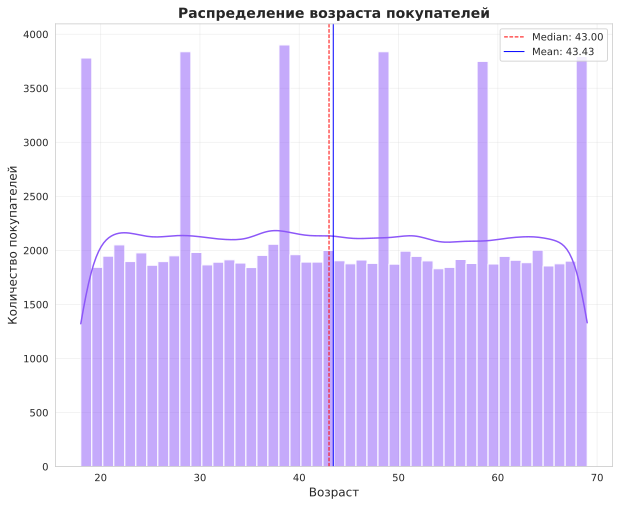

In [28]:
plt.figure(figsize=(10, 8))
sns.histplot(df['age'], color=COLOR, kde=True)
plt.title('Распределение возраста покупателей', fontsize=14, fontweight='bold')
plt.axvline(df['age'].median(), color='red', linestyle='--', linewidth=1, label=f'Median: {df['age'].median():.2f}')
plt.axvline(df['age'].mean(), color='blue', linestyle='-', linewidth=1, label=f'Mean: {df['age'].mean():.2f}')
plt.legend()
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество покупателей', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:** Распределение возраста демонстрирует умеренную структурированность с выбросами в отдельных возрастных группах. Наблюдается незначительное преобладание категории 36-45 лет при общей сбалансированности возрастного состава покупателей.

#### 4.2 Визуализируем распределение по гендеру

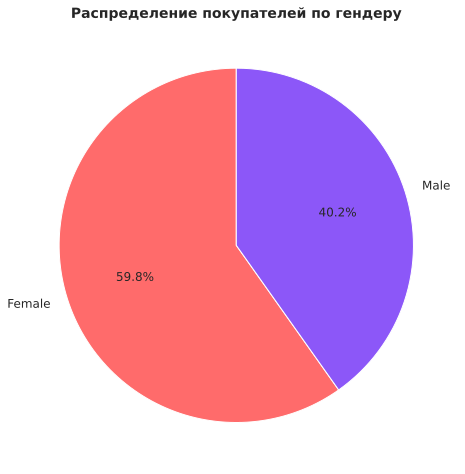

In [29]:
df_gender_cnt = df.groupby('gender').size().reset_index(name='count')
plt.figure(figsize=(8, 8))
plt.pie(df_gender_cnt['count'], labels=df_gender_cnt['gender'], colors=("#ff6b6b", COLOR), autopct='%.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title('Распределение покупателей по гендеру', fontsize=14, fontweight='bold')
plt.show()

**Вывод:** Гендерное распределение практически равномерное, что свидетельствует о сбалансированности выборки и отсутствии выраженной гендерной ориентации торговых центров в целом.

#### 4.3 Построим половозрастную пирамиду покупателей

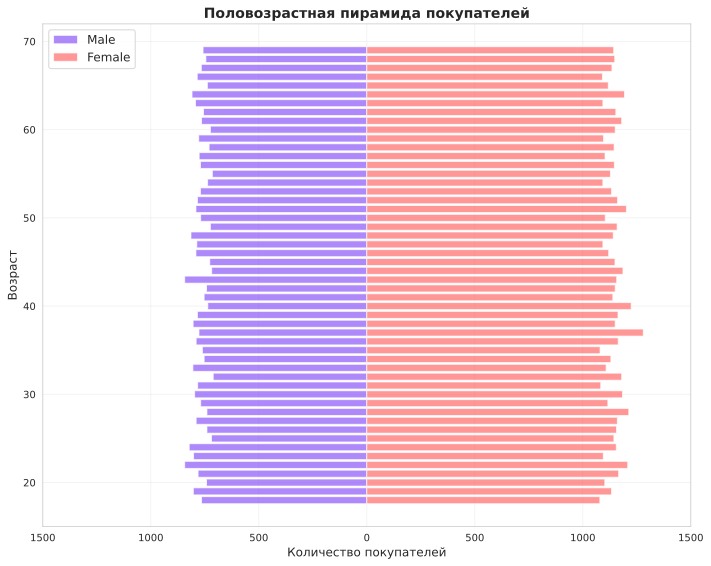

In [30]:
pivot_data = df.pivot_table(index='age',
                            columns='gender',
                            values='customer_id', 
                            aggfunc='count',
                            fill_value=0)

plt.figure(figsize=(10,8))
male_population = -pivot_data['Male']
female_population = pivot_data['Female']

plt.barh(pivot_data.index, male_population, color=COLOR, label='Male', alpha=0.7)
plt.barh(pivot_data.index, female_population, color='#ff6b6b', label='Female', alpha=0.7)

plt.xlabel('Количество покупателей', fontsize=12)
plt.ylabel('Возраст', fontsize=12)
plt.title('Половозрастная пирамида покупателей', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

max_val = max(abs(male_population).max(), female_population.max())
plt.xlim(-max_val*1.1, max_val*1.1)

xticks = plt.xticks()[0]
plt.xticks(xticks, [abs(int(x)) for x in xticks])

plt.grid(True, alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:** Половозрастная пирамида демонстрирует относительно равномерное распределение по полу во всех возрастных группах.

#### 4.4 Проанализируем динамику продаж по годам и месяцам

Построим два графика для анализа временных рядов: первый показывает динамику общей суммы продаж, второй - количество покупок

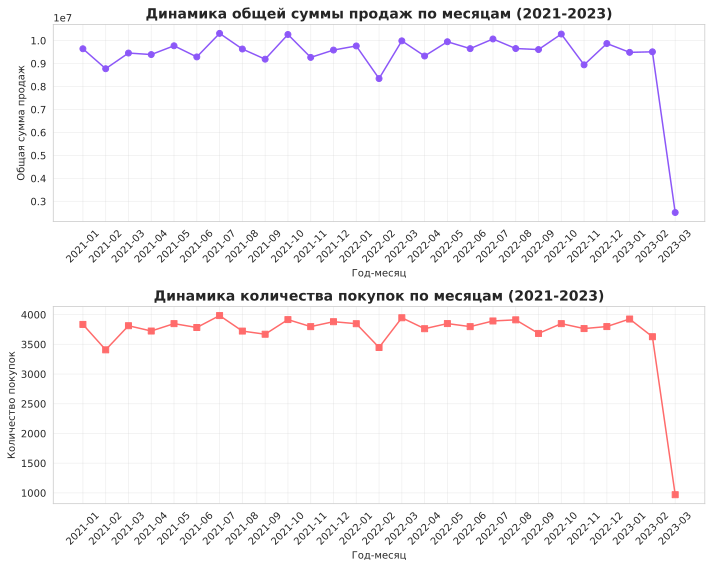

In [31]:
monthly_sales = df.groupby(['year', 'month'])['purchase_sum'].agg(['sum', 'count']).reset_index()
monthly_sales['year_month'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(monthly_sales['year_month'], monthly_sales['sum'], marker='o', color=COLOR, linewidth=1.5)
plt.title('Динамика общей суммы продаж по месяцам (2021-2023)', fontsize=14, fontweight='bold')
plt.xlabel('Год-месяц')
plt.ylabel('Общая сумма продаж')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.subplot(2, 1, 2)
plt.plot(monthly_sales['year_month'], monthly_sales['count'], marker='s', color='#ff6b6b', linewidth=1.5)
plt.title('Динамика количества покупок по месяцам (2021-2023)', fontsize=14, fontweight='bold')
plt.xlabel('Год-месяц')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:** 
- Наблюдается четкая сезонность продаж с пиками в определенные месяцы
- Заметен небольшой рост продаж в 2022 году по сравнению с 2021 в большинстве месяцев
- Март 2023 года показывает аномально низкие показатели, что объясняется неполными данными (наблюдения только за первую неделю месяца). Однако стоит заметить, что в первые месяцы 2023 года наблюдается положительная динамика по сравнению с аналогичным периодом прошлых лет

#### 4.5 Исследуем зависимость количества покупок от дня недели и месяца

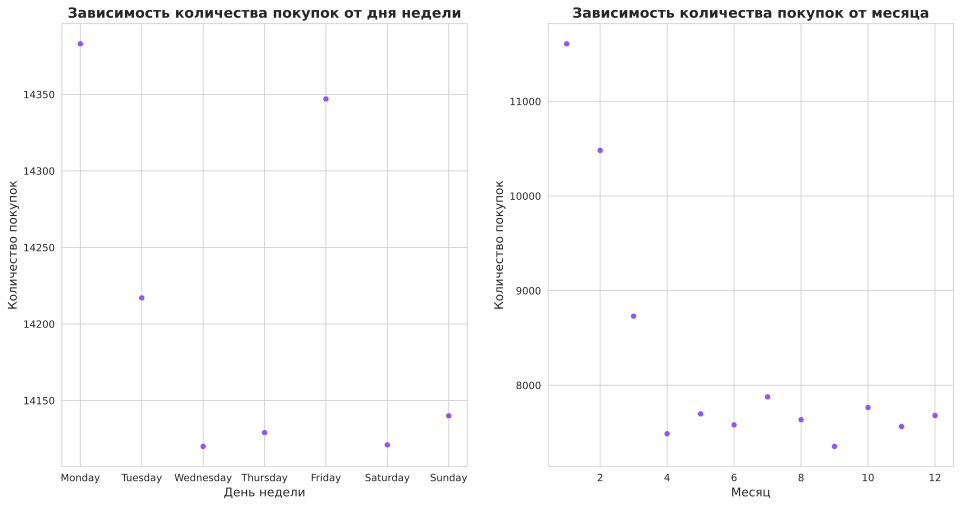

In [32]:
names = {'day_of_week': 'дня недели', 'month': 'месяца'}
names_labels = {'day_of_week': 'День недели', 'month': 'Месяц'}
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(figsize=(16,8), ncols=2)
for i, feature in enumerate(['day_of_week', 'month']):
  plot_data = df.groupby(feature).size().reset_index(name='count')
  if feature == 'day_of_week':
    plot_data[feature] = pd.Categorical(plot_data[feature], categories=day_order, ordered=True)
  sns.scatterplot(x = feature, y = 'count', data = plot_data, ax = axs[i], color=COLOR)
  axs[i].set_xlabel(names_labels[feature], fontsize=12)
  axs[i].set_ylabel("Количество покупок", fontsize=12)
  axs[i].set_title(f"Зависимость количества покупок от {names[feature]}", fontsize=14, fontweight='bold')

**Вывод:** 
- **По дням недели:** Наблюдается атипичный паттерн покупательской активности с пиками в понедельник и пятницу, что отличается от классической розничной модели с максимумом в выходные дни. Данное распределение может свидетельствовать о специфическом поведении аудитории торговых центров Стамбула, возможно связанном с рабочим графиком определенных категорий населения, туристическим потоком, распределенным по неделе, акционными программами, привязанными к началу и концу недели.
- **По месяцам:** Выявлен выраженный сезонный тренд с максимальной покупательской активностью с января по март. Этот период может быть обусловлен последогодними распродажами, подготовкой к весеннему сезону, особенностями туристического потока в зимние месяцы или сезонными акциями.

#### 4.6 Визуализируем количество покупок по категориям товаров

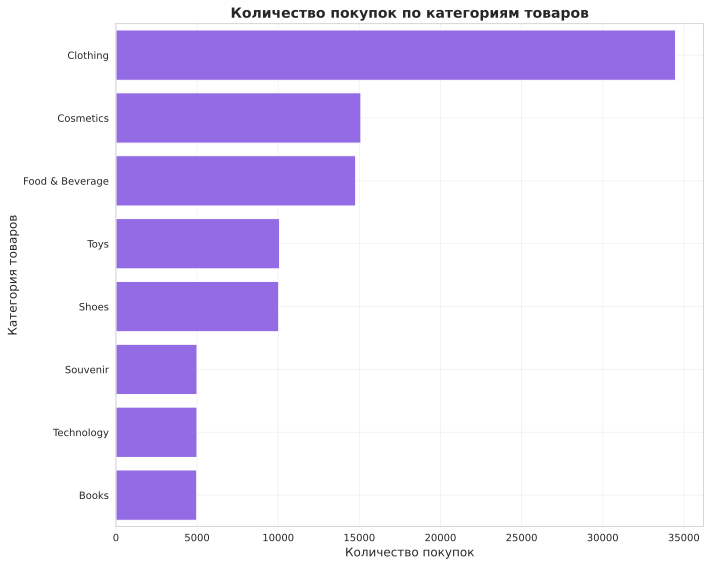

In [33]:
plt.figure(figsize=(10,8))
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index, color=COLOR, orient='h')
plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Категория товаров', fontsize=12)
plt.title('Количество покупок по категориям товаров', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:** Наиболее популярными категориями являются `Одежда`, `Косметика` и `Еда и напитки`, а наименьший спрос на `Книги`. Это отражает специфику спроса в торговых центрах (импульсные и бытовые покупки).

### 4.7 Посмотрим на распределение цен по категориям товаров

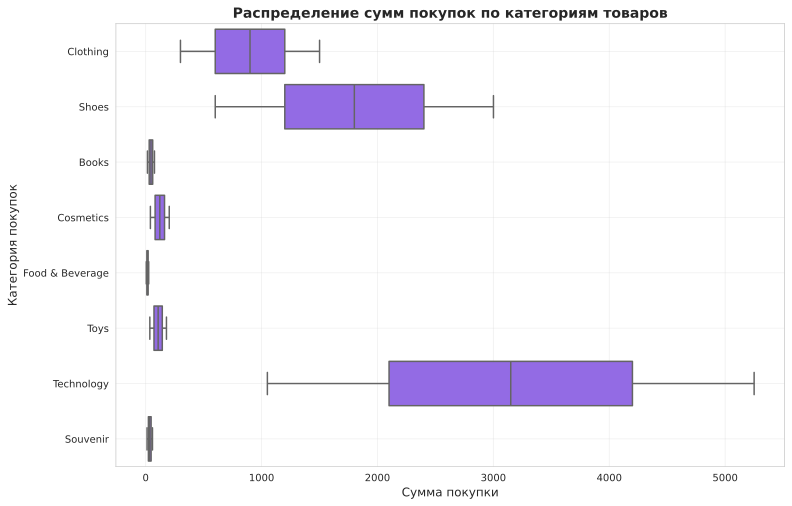

In [34]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='price', y='category', orient='h', color = COLOR, fliersize=3, linewidth=1.5)
plt.ylabel("Категория покупок", fontsize=12)
plt.xlabel("Сумма покупки", fontsize=12)
plt.title("Распределение сумм покупок по категориям товаров", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

**Вывод:** Категории `Технологии` и `Обувь` имеют самый широкий разброс цен и наибольшие медианные цены. Категория `Еда и напитки` имеет самые низкие и стабильные цены.

### 4.8 Проанализируем сезонные изменения цен в каждой категории товаров

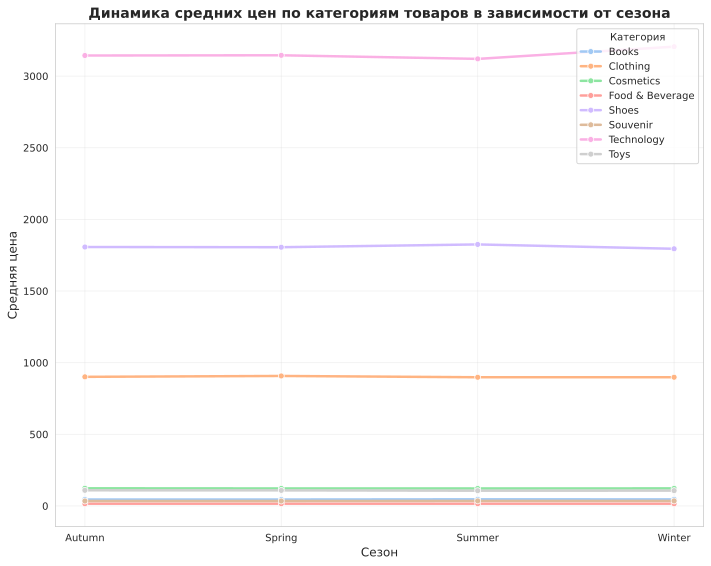

In [35]:
seasonal_prices = df.groupby(['season', 'category'])['price'].mean().reset_index()
plt.figure(figsize=(10, 8))
sns.lineplot(data=seasonal_prices, x='season', y='price', hue='category',marker='o',linewidth=2.5, palette=colors)

plt.title('Динамика средних цен по категориям товаров в зависимости от сезона', fontsize=14, fontweight='bold')
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Средняя цена', fontsize=12)
plt.legend(loc='upper right', title='Категория')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:** Анализ сезонной динамики цен выявил стабильность в большинстве товарных категорий при небольших колебаниях в сегменте `Технологии`, где наблюдается зимний рост цен, в то время как другие категории сохраняют относительно постоянный ценовой уровень в течение года.

### 4.9 Посмотрим, как распределены по популярности категории товаров в каждой возрастной группе покупателей

Для начала стоит посмотреть на количество покупок в каждой возрастной группе в целом

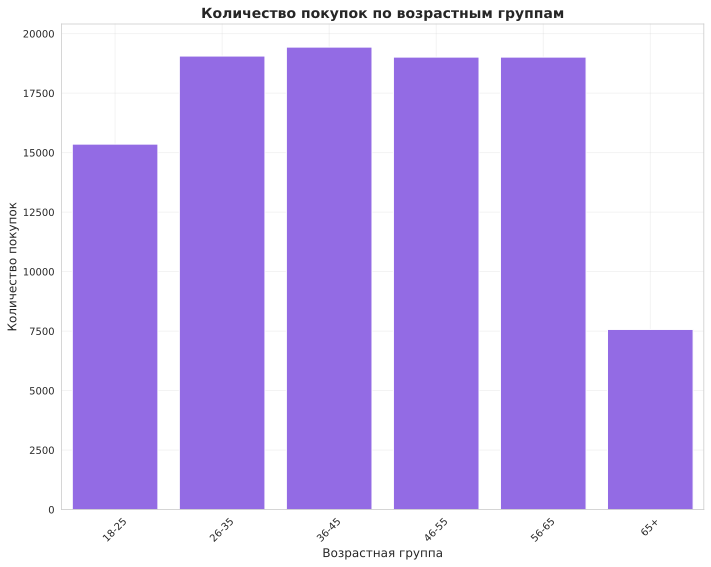

In [36]:
age_data = df.groupby(['age_group']).size().reset_index(name='cnt')
plt.figure(figsize=(10, 8))
sns.barplot(x='age_group', y='cnt', data=age_data, color=COLOR)
plt.xlabel("Возрастная группа", fontsize=12)
plt.ylabel("Количество покупок", fontsize=12)
plt.title("Количество покупок по возрастным группам", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

Теперь визуализируем распределение покупок по категориям товаров в каждой возрастной группе

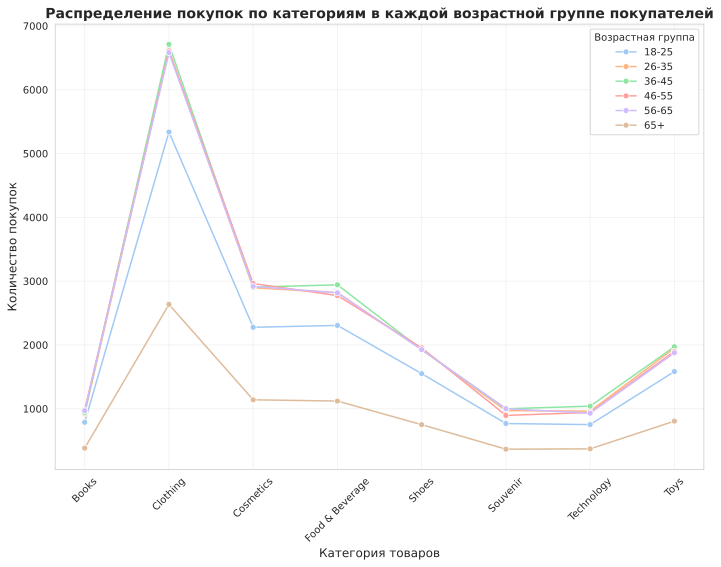

In [37]:
plt.figure(figsize=(10, 8))
category_age_data = df.groupby(['category', 'age_group']).size().reset_index(name='cnt')

sns.lineplot(x='category', y='cnt', data=category_age_data, hue='age_group', marker='o', palette=colors)
plt.xlabel("Категория товаров", fontsize=12)
plt.ylabel("Количество покупок", fontsize=12)
plt.title("Распределение покупок по категориям в каждой возрастной группе покупателей", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:** Анализ покупательского поведения различных возрастных групп выявил как универсальные тренды, так и возрастную специфику:
1. Универсальный тренд: Категория `Одежда` является абсолютным лидером по количеству покупок во всех возрастных группах, что позволяет классифицировать ее как базовую потребительскую категорию для торговых центров
2. Возрастная специфика: Молодежь (18-25 лет) демонстрирует относительно низкую покупательскую активность, что может быть связано с перераспределением потребительских расходов в пользу цифровых технологий, образования и развлечений, а также с формирующимся уровнем доходов. Группа 65+ является наименее активной в целом, что логично объясняется снижением частоты и объема шопинга в пенсионном возрасте.

### 4.10 Исследуем взаимосвязь между сезонностью, выбором платежного инструмента и величиной среднего чека

Построим тепловую карту, которая визуализирует средний чек в разрезе сезонов и методов оплаты, где интенсивность цвета отражает величину среднего чека

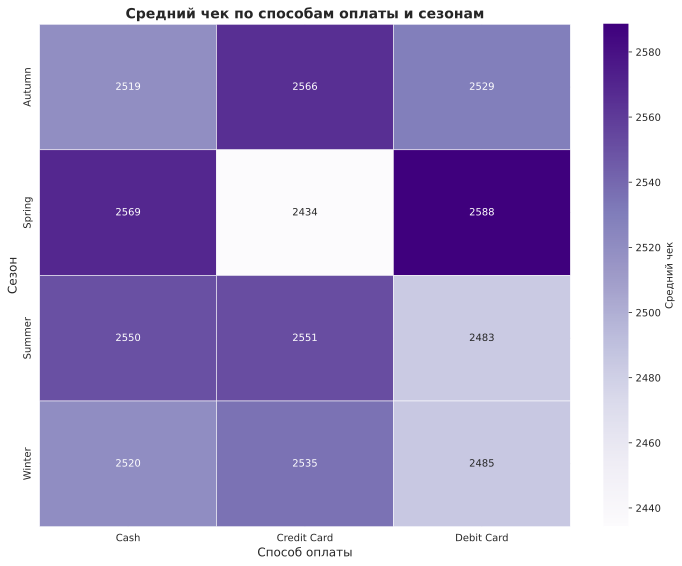

In [38]:
plt.figure(figsize=(10, 8))
avg_check_payment = df.groupby(['season', 'payment_method'])['purchase_sum'].mean().unstack()
sns.heatmap(avg_check_payment, 
            annot=True, 
            fmt='.0f', 
            cmap='Purples',
            linewidths=0.5,
            cbar_kws={'label': 'Средний чек'})

plt.xlabel('Способ оплаты', fontsize=12)
plt.ylabel('Сезон', fontsize=12)
plt.title('Средний чек по способам оплаты и сезонам', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Вывод:**
- Наибольший средний чек весной демонстрируют дебетовые карты и наличные, тогда как кредитные карты показывают неожиданно низкие значения в этот сезон
- Кредитные карты в целом сохраняют стабильно высокие показатели в течение года, в то время как дебетовые карты подвержены умеренным сезонным колебаниям
- Наибольшая амплитуда сезонных колебаний характерна для кредитных карт, тогда как наличные расчеты демонстрируют наименьшую изменчивость

### 4.11 Визуализируем распределение доходов по торговым центрам

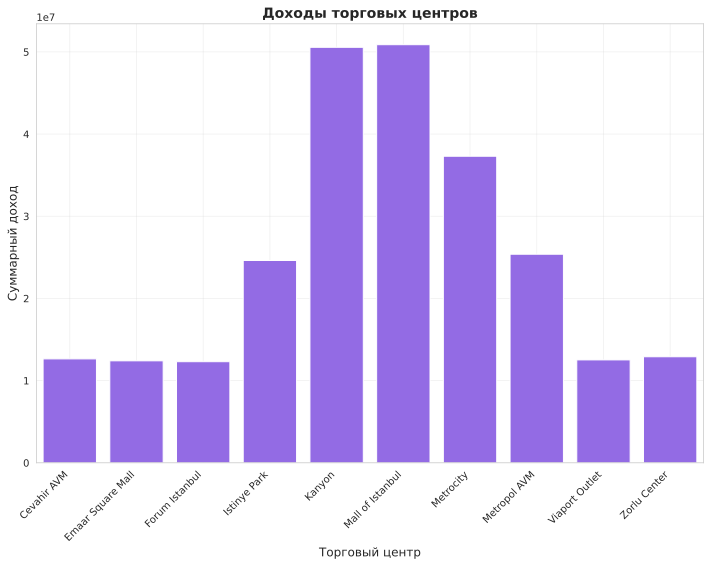

In [39]:
df_mall_income = df.groupby(by=['shopping_mall'])['purchase_sum'].sum().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data=df_mall_income, x='shopping_mall', y='purchase_sum', color=COLOR)
plt.xlabel('Торговый центр', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Суммарный доход', fontsize=12)
plt.title('Доходы торговых центров', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:** Наблюдается значительный разброс в выручке между торговыми центрами. Лидеры — `Mall of Istanbul`, `Kanyon`. Это может быть связано с их расположением, площадью, арендаторами, ассортиментом или ценовым позиционированием.

### 4.12 Проведем анализ ценового позиционирования: сравним средние чеки для выявления премиальных и массовых торговых центров

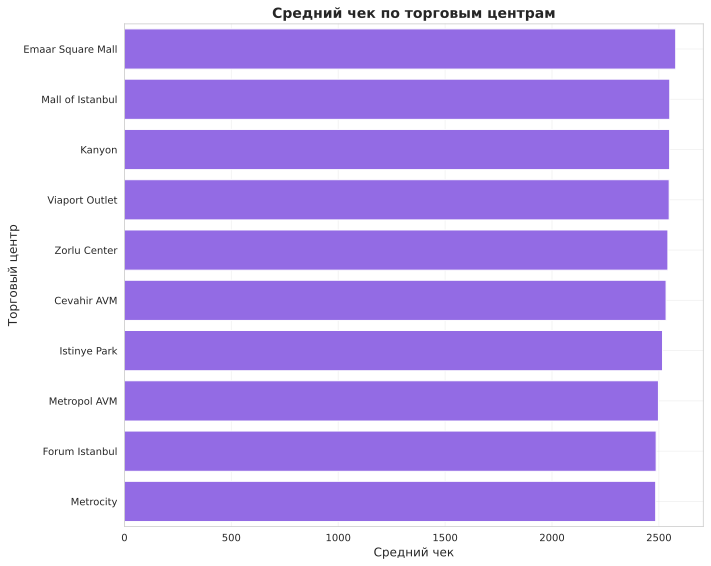

In [40]:
mall_avg_check = df.groupby('shopping_mall')['purchase_sum'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=mall_avg_check.values, y=mall_avg_check.index, color=COLOR)
plt.title('Средний чек по торговым центрам', fontsize=14, fontweight='bold')
plt.xlabel('Средний чек', fontsize = 12)
plt.ylabel('Торговый центр', fontsize = 12)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

**Вывод:** Распределение среднего чека между торговыми центрами практически одинаковое, без существенных ценовых различий.

## 5. Проверка гипотез

In [41]:
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

### 1. **Исследовательский вопрос:** Влияет ли способ оплаты на среднюю сумму покупки?


---

**Гипотеза:** Покупатели, использующие кредитные карты, совершают более крупные покупки, чем те, кто платит наличными
- `H0` Средняя сумма покупки кредитными картами <= наличными
- `H1`: Средняя сумма покупки кредитными картами > наличными

Text(0, 0.5, 'Средняя сумма покупки')

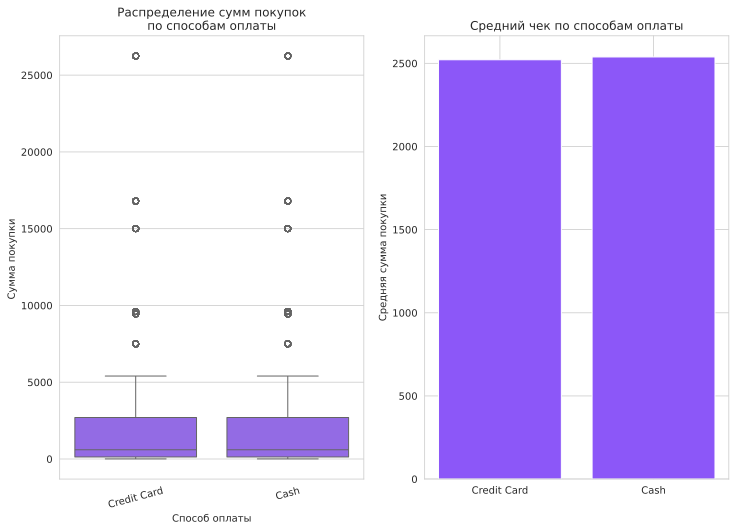

In [42]:
credit_amount = df[df['payment_method'] == 'Credit Card']['purchase_sum']
cash_amount = df[df['payment_method'] == 'Cash']['purchase_sum']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
payment_data = df[df['payment_method'].isin(['Credit Card', 'Cash'])]
sns.boxplot(data=payment_data, x='payment_method', y='purchase_sum', color=COLOR)
plt.title('Распределение сумм покупок\nпо способам оплаты')
plt.xlabel('Способ оплаты')
plt.ylabel('Сумма покупки ')
plt.xticks(rotation=15)


plt.subplot(1, 2, 2)
means = [credit_amount.mean(), cash_amount.mean()]
methods = ['Credit Card', 'Cash']
bars = plt.bar(methods, means, color=COLOR)
plt.title('Средний чек по способам оплаты')
plt.ylabel('Средняя сумма покупки')

In [43]:
res = st.ttest_ind(credit_amount, cash_amount, equal_var=False, alternative='greater')

print(f"  t-статистика: {res.statistic:.4f}")
print(f"  p-значение: {res.pvalue:.4e}")
print(f"  Средняя сумма покупки при оплате кредитной картой: {credit_amount.mean():.2f}")
print(f"  Средняя сумма покупки при оплате наличными: {cash_amount.mean():.2f}")

if res.pvalue < 0.05:
    print("\nВывод:")
    print("  Отвергаем нулевую гипотезу (H0).")
else:
    print("\nВывод:")
    print("  Не удалось отвергнуть нулевую гипотезу (H0).")

  t-статистика: -0.5668
  p-значение: 7.1458e-01
  Средняя сумма покупки при оплате кредитной картой: 2521.46
  Средняя сумма покупки при оплате наличными: 2538.58

Вывод:
  Не удалось отвергнуть нулевую гипотезу (H0).


**Гипотеза не подтверждена** Нет статистически значимых доказательств того, что покупатели с кредитными картами совершают покупки на большие суммы по сравнению с покупателями, использующими наличные.

**Практическая интерпретация:**
Наблюдаемая разница в средних чеках является статистически незначимой и может быть объяснена случайными колебаниями в данных. Способ оплаты не оказывает существенного влияния на сумму покупки.

### 2. **Исследовательский вопрос:** Влияет ли сезон на количество совершаемых покупок?


---

**Гипотеза:** В зимний сезон совершается больше покупок, чем в летний
- `H0` Количество покупок зимой <= летом
- `H1`: Количество покупок зимой > летом

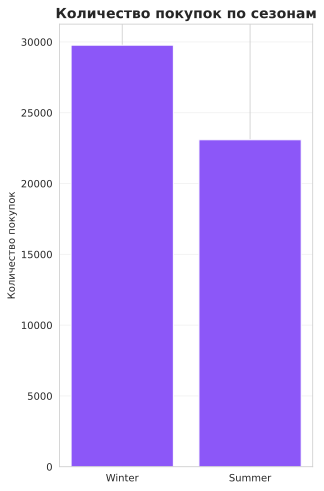

In [44]:
winter_purchases = df[df['season'] == 'Winter']['invoice_no'].count()
summer_purchases = df[df['season'] == 'Summer']['invoice_no'].count()

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
seasons = ['Winter', 'Summer']
purchases = [winter_purchases, summer_purchases]

bars = plt.bar(seasons, purchases, color=COLOR)
plt.title('Количество покупок по сезонам', fontsize=14, fontweight='bold')
plt.ylabel('Количество покупок')
plt.grid(axis='y', alpha=0.3)

In [45]:
count = [winter_purchases, summer_purchases]
nobs = [len(df)] * 2
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"  z-статистика: {z_stat:.4f}")
print(f"  p-значение: {p_value:.4f}")
print(f"  Зимние покупки: {winter_purchases:,} ({winter_purchases/len(df)*100:.1f}%)")
print(f"  Летние покупки: {summer_purchases:,} ({summer_purchases/len(df)*100:.1f}%)")

if p_value < 0.05:
    print("\nВывод:")
    print("  Отвергаем нулевую гипотезу (H0).")
else:
    print("\nВывод:")
    print("  Не удалось отвергнуть нулевую гипотезу (H0).")

  z-статистика: 33.8911
  p-значение: 0.0000
  Зимние покупки: 29,770 (29.9%)
  Летние покупки: 23,093 (23.2%)

Вывод:
  Отвергаем нулевую гипотезу (H0).


**Гипотеза подтверждена** Статистически доказано, что в зимний сезон в торговых центрах Стамбула совершается больше покупок, чем в летний.

**Практическая интерпретация:**
Наблюдается выраженная сезонность покупательской активности с пиком в зимний период. Зимой совершается на 30% больше покупок по сравнению с летним сезоном, что может быть связано с праздничным сезоном, распродажами и более благоприятными условиями для шопинга. Сезон оказывает значительное влияние на количество совершаемых покупок, с четким преобладанием зимних покупок над летними.

### 3. **Исследовательский вопрос:** Влияет ли пол покупателя на частоту покупок товаров категории `Техника`?

**Гипотеза:** Мужчины чаще покупают товары категории `Техника`, чем женщины
- `H₀`: Доля покупок товаров категории `Техника` мужчинами <= доли среди женщин  
- `H₁`: Доля покупок товаров категории `Техника` мужчинами > доли среди женщин

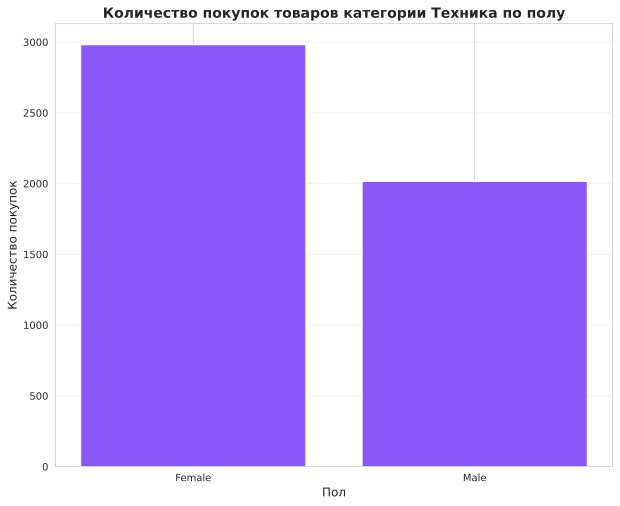

In [46]:
tech_data = df[df['category'] == 'Technology']
gender_tech_counts = tech_data['gender'].value_counts()

plt.figure(figsize=(10,8))

bars = plt.bar(gender_tech_counts.index, gender_tech_counts.values, color=COLOR)
plt.title('Количество покупок товаров категории Техника по полу', fontsize=14, fontweight='bold')
plt.ylabel('Количество покупок', fontsize=12)
plt.xlabel('Пол', fontsize=12)
plt.grid(axis='y', alpha=0.3)

In [47]:
male_tech = df[(df['gender'] == 'Male') & (df['category'] == 'Technology')].shape[0]
female_tech = df[(df['gender'] == 'Female') & (df['category'] == 'Technology')].shape[0]

count = [male_tech, female_tech]
nobs = [male_tech+female_tech] * 2
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"  z-статистика: {z_stat:.4f}")
print(f"  p-значение: {p_value:.4f}")
print(f"  Мужчины: {male_tech} ({male_tech/(male_tech+female_tech)*100:.1f}%)")
print(f"  Женщины: {female_tech} ({female_tech/(male_tech+female_tech)*100:.1f}%)")

if p_value < 0.05:
    print("\nВывод:")
    print("  Отвергаем нулевую гипотезу (H0).")
else:
    print("\nВывод:")
    print("  Не удалось отвергнуть нулевую гипотезу (H0).")

  z-статистика: -19.3277
  p-значение: 1.0000
  Мужчины: 2015 (40.3%)
  Женщины: 2981 (59.7%)

Вывод:
  Не удалось отвергнуть нулевую гипотезу (H0).


**Гипотеза не подтверждена** Нет статистически значимых доказательств того, что мужчины покупают товары категории `Техника` чаще, чем женщины.

**Практическая интерпретация:** Пол покупателя не оказывает статистически значимого влияния в предполагаемом направлении (мужчины > женщины) на частоту покупок техники. Фактически наблюдается противоположная тенденция с большей долей покупок техники среди женщин в торговых центрах Стамбула. Это может быть связано с различными факторами, включая различия в покупательских привычках, составе покупаемых товаров или маркетинговых стратегиях, ориентированных на женскую аудиторию.

## Общий вывод

Для выявления ключевых факторов, влияющих на покупательское поведение в торговых центрах Стамбула, был проведен комплексный анализ данных о транзакциях за период с января 2021 по март 2023 года. В результате исследования установлено, что:

**Демографические паттерны:**
- Основную целевую аудиторию составляют клиенты зрелого возраста (36-45 лет) со средним возрастом 43 года
- Гендерное распределение покупателей сбалансировано с незначительным преобладанием женской аудитории

**Финансовые показатели:**
- Наблюдается значительный разброс в ценовой политике при среднем чеке 2 528.79 лир
- Стандартная корзина покупок включает 3 товарные позиции

**Территориальное распределение:**
- Все 6 анализируемых торговых центров демонстрируют равномерную посещаемость
- Универсальность товарного предложения подтверждается отсутствием выраженной гендерной или возрастной специализации

Данные статистические выводы можно использовать для разработки целевых стратегии для различных демографических групп с учетом их покупательской способности и предпочтений.